In [1]:
pip install psycopg2

Note: you may need to restart the kernel to use updated packages.


First few rows of the processed dataset:
             timestamp symbol    open    high    low   close  volume  \
0  2024-12-11 18:20:00   AAPL  246.73  246.82  246.7  246.72    1631   
1  2024-12-11 18:20:00   AAPL  246.73  246.82  246.7  246.72    1631   
2  2024-12-11 18:20:00   AAPL  246.73  246.82  246.7  246.72    1631   
3  2024-12-11 18:20:00   AAPL  246.73  246.82  246.7  246.72    1631   
4  2024-12-11 18:20:00   AAPL  246.73  246.82  246.7  246.72    1631   

   close_moving_avg  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4            246.72  


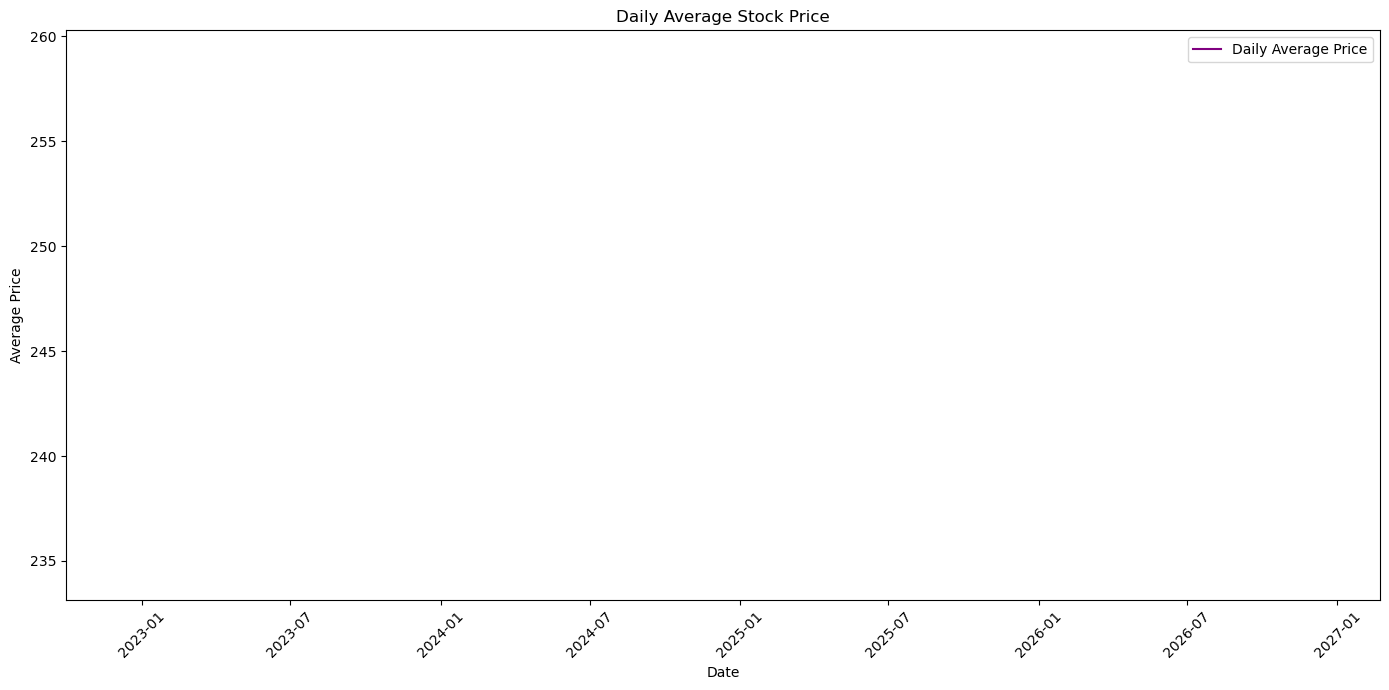

Successfully connected to the database
Data successfully inserted into the stock_prices table.
Aggregated data successfully inserted into the daily_avg_prices table.
PostgreSQL connection closed.


In [12]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

# Load the processed data (assuming it's stored in a CSV file from the previous notebook)
df = pd.read_csv('processed_stock_data.csv')

# Display the first few rows to verify the data
print("First few rows of the processed dataset:")
print(df.head())

# Data Aggregation (if needed)
# For example, let's calculate the daily average stock price (or any other aggregation needed)
df['date'] = pd.to_datetime(df['timestamp']).dt.date
daily_avg_price = df.groupby('date')['close'].mean().reset_index()

# Visualize the daily average stock price
plt.figure(figsize=(14, 7))
plt.plot(daily_avg_price['date'], daily_avg_price['close'], label='Daily Average Price', color='purple')
plt.title('Daily Average Stock Price')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Storing Data in PostgreSQL Database using psycopg2

# Initialize connection variable
connection = None

# Replace with your actual PostgreSQL connection details (pgAdmin 4 should show these)
try:
    connection = psycopg2.connect(
        host='localhost',         # Or the host where your PostgreSQL server is hosted
        user='postgres',          # PostgreSQL username (pgAdmin 4)
        password='hellen',        # PostgreSQL password (pgAdmin 4)
        dbname='processed_stock', # Your target database
        port='5434'               # Specify the correct port (5434)
    )

    if connection:
        print("Successfully connected to the database")

        # Create a cursor object
        cursor = connection.cursor()

        # Create table for stock prices if not exists
        cursor.execute("""
        CREATE TABLE IF NOT EXISTS stock_prices (
            id SERIAL PRIMARY KEY,
            timestamp TIMESTAMP,
            open FLOAT,
            high FLOAT,
            low FLOAT,
            close FLOAT,
            volume INT
        )
        """)

        # Insert the processed stock data into the stock_prices table
        for index, row in df.iterrows():
            cursor.execute("""
            INSERT INTO stock_prices (timestamp, open, high, low, close, volume)
            VALUES (%s, %s, %s, %s, %s, %s)
            """, (row['timestamp'], row['open'], row['high'], row['low'], row['close'], row['volume']))

        # Commit the transaction
        connection.commit()
        print("Data successfully inserted into the stock_prices table.")

        # Create table for daily average stock prices if not exists
        cursor.execute("""
        CREATE TABLE IF NOT EXISTS daily_avg_prices (
            id SERIAL PRIMARY KEY,
            date DATE,
            avg_price FLOAT
        )
        """)

        # Insert aggregated daily average price data
        for index, row in daily_avg_price.iterrows():
            cursor.execute("""
            INSERT INTO daily_avg_prices (date, avg_price)
            VALUES (%s, %s)
            """, (row['date'], row['close']))

        # Commit the transaction
        connection.commit()
        print("Aggregated data successfully inserted into the daily_avg_prices table.")

except Exception as e:
    print("Error while connecting to PostgreSQL:", e)

finally:
    # Ensure that the connection is closed properly
    if connection:
        cursor.close()
        connection.close()
        print("PostgreSQL connection closed.")
